In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from PIL import Image
import pandas as pd
import torch.utils.data as data

torch.__version__,torchvision.__version__

('2.0.1+cu117', '0.15.2+cu117')

In [2]:
!pip install git+https://github.com/ncullen93/torchsample
!pip install einops


  Cloning https://github.com/ncullen93/torchsample to c:\users\deepe\appdata\local\temp\pip-req-build-ihx902_j
  Resolved https://github.com/ncullen93/torchsample to commit 1f328d1ea3ef533c8c0c4097ed4a3fa16d784ba4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ncullen93/torchsample 'C:\Users\deepe\AppData\Local\Temp\pip-req-build-ihx902_j'


In [3]:
root_directory = 'data/MRNet-v1.0/'

In [4]:
import einops, math

def patchify(x,ps=4):
    return einops.rearrange(x,"b c (h p1) (w p2)-> b (h w) (p1 p2 c)",p1=ps,p2=ps)

def unpatchify(x,ps=4):
    return einops.rearrange(x,"b (h w) (p1 p2 c) -> b c (h p1) (w p2)",p1=ps,p2=ps, h=int(math.sqrt(x.shape[1])))


In [5]:
## implementation
import math
from functools import partial
import numpy as np

import torch
import torch.nn as nn

import warnings

def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        tensor.uniform_(2 * l - 1, 2 * u - 1)

        tensor.erfinv_()

        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.requires_attn = True

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x) # B, N, 3, self.num_heads x C // self.num_heads
        if self.requires_attn:
            qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2] # 1, B, self.num_heads, N, C // self.num_heads
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        else:
            qkv = qkv.reshape(B, N, 3,C)
            x = qkv[:,:,2]
            attn = None
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # print(f'embeded patch {x.shape}')
        B, C, H, W = x.shape
        # print(x.shape)
        ####################### write your answer here #######################
        # instruction: you need to project features from patch pixels with 3xpatch_sizexpatch_size to a token with embed_dim
        
        ####################### write your answer here ####################### 
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(2*embed_dim, num_classes) if num_classes > 0 else nn.Identity()


        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}
    
    def prepare_tokens(self, x):
        # print(f"prepare token shape {x.shape}")
        B, nc, w, h = x.shape
        x = self.patch_embed(x)
        B,N,C = x.shape
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        ####################### write your answer here ####################### 
        # instruction: you need to add cls_tokens to the sequence. After this, the shape of x should be (B, N+1, C)
        ####################### write your answer here ####################### 
        # assert x.shape[1] == N + 1
        x = torch.cat((cls_tokens, x), dim=1)
        
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)
    
    def forward_features(self, x):
        # print(f'first {x.shape}')
        x = torch.squeeze(x, dim=0)
        # print(f'second {x.shape}')
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
            
        x = self.norm(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
                
        return self.head( torch.cat( (x[:, 0], torch.mean(x[:, 1:], dim=1)), dim=1 ) ) 


def vit_tiny(patch_size=4, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_little(patch_size=4, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=64, depth=4, num_heads=4, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [6]:
from torchvision import datasets, transforms
class MRDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])[5]
        # array = np.expand_dims(array, axis=0)
        # array = np.stack((array,)*3, axis=1)[0]
        # array = np.stack((array,)*3, axis=1)
        # slice_index = 5
        # axis = 0
        # slice_2d = array.take(indices=slice_index, axis=axis)

        # array = Image.fromarray(slice_2d).resize((224, 224), Image.BILINEAR)
        # array = np.array(array)
        # array = np.expand_dims(array, axis=2)
        # array = np.repeat(array, 1, axis=2)

        # print(array.shape)
        label = self.labels[index]
        label = torch.FloatTensor([label])
        
        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=0)
            array = torch.FloatTensor(array)
            # print(f'final array shape {array.shape}')
            # array = transforms.RandomResizedCrop(array, scale=(0.2, 1.0), interpolation=3)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label

In [7]:
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np

import torch
import torch.optim as optim
from torchsample.transforms import RandomRotate, RandomTranslate, RandomFlip, Compose
from torchvision import transforms

# from tensorboardX import SummaryWriter

from sklearn import metrics

In [8]:
# now load a train set and a validation set
# data = datasets.CIFAR10("data",transform=tfms,download=True, )
# train_dl = torch.utils.data.DataLoader(data,256,shuffle=True,num_workers=8,pin_memory=True)

task = 'meniscus'
plane = 'axial'

augmentor = Compose([
        transforms.Lambda(lambda x: torch.Tensor(x)),
        # RandomRotate(25),
        RandomTranslate([0.11, 0.11]),
        RandomFlip(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(1, 0, 2, 3)),
    ])

# train_dataset = MRDataset(root_directory, task,
#                               plane, transform=augmentor, train=True)

train_dataset = MRDataset(root_directory, task,
                              plane, train=True)
# train_dl = torch.utils.data.DataLoader(
        # train_dataset, batch_size=1, shuffle=True, drop_last=False)

train_dl = torch.utils.data.DataLoader(
         train_dataset, batch_size=32, shuffle=True, drop_last=False)


# data = datasets.CIFAR10("data",False,transform=tfms,download=True)
# val_dl = torch.utils.data.DataLoader(data,64,shuffle=False,num_workers=4)

validation_dataset = MRDataset(
        root_directory, task, plane, train=False)
# val_dl = torch.utils.data.DataLoader(
#     validation_dataset, batch_size=1, shuffle=-True, num_workers=4, drop_last=False)

val_dl = torch.utils.data.DataLoader(
     validation_dataset, batch_size=3, shuffle=-True, drop_last=False)

#  Create Model
device = "cuda"
model = vit_small(16,img_size=224,num_classes=1)
model = model.to(device)

# load the pretrained weights
state = torch.load("SiT_Small_ImageNet.pth")
state = {k.replace("module.backbone.",""):v for k,v in state['teacher'].items()} # extract the model weights!
print("Loading weights: ", model.load_state_dict(state,strict=False))

# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
from torch import optim
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

Loading weights:  _IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['module.head.mlp.0.weight', 'module.head.mlp.0.bias', 'module.head.mlp.1.weight', 'module.head.mlp.1.bias', 'module.head.mlp.1.running_mean', 'module.head.mlp.1.running_var', 'module.head.mlp.1.num_batches_tracked', 'module.head.mlp.3.weight', 'module.head.mlp.3.bias', 'module.head.mlp.4.weight', 'module.head.mlp.4.bias', 'module.head.mlp.4.running_mean', 'module.head.mlp.4.running_var', 'module.head.mlp.4.num_batches_tracked', 'module.head.mlp.6.weight', 'module.head.mlp.6.bias', 'module.head.mlp.7.running_mean', 'module.head.mlp.7.running_var', 'module.head.mlp.7.num_batches_tracked', 'module.head_recons.mlp.0.weight', 'module.head_recons.mlp.0.bias', 'module.head_recons.mlp.2.weight', 'module.head_recons.mlp.2.bias', 'module.head_recons.mlp.4.weight', 'module.head_recons.mlp.4.bias', 'module.head_recons.convTrans.weight', 'module.head_recons.convTrans.bias'])


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
# torch.squeeze(next(iter(train_dl))[0].float(), dim=0).shape

In [10]:
import tqdm

def train_one_epoch(dl,model, opt, device):
    model.train()
    pbar = tqdm.tqdm(dl)
    for x,label in pbar:
        x,label = x.float().to(device),label.to(device)
        pred = model(x).float()
        # pred = torch.argmax(pred, 1).unsqueeze(1)
        # print(label)
        # softmax = nn.Softmax(dim=1)
        # pred = softmax(pred)
        # loss = nn.functional.cross_entropy(pred,label)
        
        loss = nn.BCEWithLogitsLoss()
        loss = loss(pred,label)
        # loss = nn.MSELoss(pred,label)
        loss.backward()
        opt.step()
        opt.zero_grad()
        pbar.set_description(f"loss: {loss.item():.3f}")

@torch.no_grad()
def eval_one_epoch(dl,model, device):
    model.eval()
    pbar = tqdm.tqdm(dl)
    def _f():
        for x,label in pbar:
            x,label = x.to(device),label.to(device)
            pred = model(x).float()
            # pred = torch.argmax(pred, 1).unsqueeze(1)
            # softmax = nn.Softmax(dim=1)
            # pred = softmax(pred)
            # loss = nn.functional.cross_entropy(pred,label)
            
            loss = nn.BCEWithLogitsLoss()
            loss = loss(pred,label)
            # loss = nn.MSELoss(pred,label)
            acc = (pred.argmax(1)==label).float().mean()
            pbar.set_description(f"loss: {loss.item():.3f}, acc: {acc.item():.3f}")
            yield pred.argmax(1),label
    out = list(_f())
    pred, y = list(zip(*out))
    return torch.cat(pred),torch.cat(y)
        

In [11]:
# this implementation achieves roughly an accuracy of 0.64.
num_epoch = 5
log=[]
for epoch in range(num_epoch):
    train_one_epoch(train_dl,model, optimizer, device)
    if epoch%10==0:
        pred,y = eval_one_epoch(val_dl,model, device)
        acc = (pred==y).float().mean().item()        
        log.append(acc)
        print(epoch, acc)

loss: 0.696, acc: 0.667: 100%|██████████| 40/40 [00:01<00:00, 30.62it/s]


0 0.5666666626930237


loss: 0.556: 100%|██████████| 36/36 [00:11<00:00,  3.12it/s]


<Axes: >

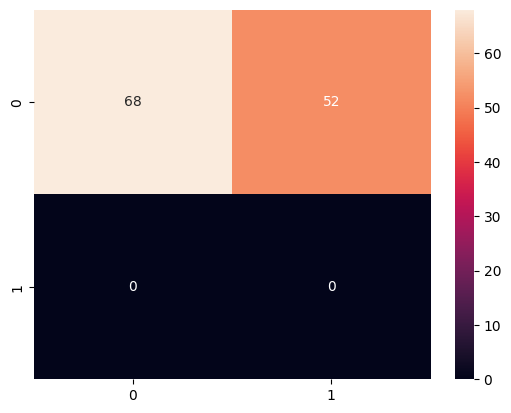

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# pred,y = eval_one_epoch(val_dl,model, device)
cf_max=confusion_matrix(pred.cpu(),y.cpu())
sns.heatmap(cf_max,annot=True,fmt='g')

In [13]:
pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')